# Analyze Eye Gaze Data

In [51]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import pickle
from statsmodels.robust.scale import mad
from utils import *

from eye_gaze_analysis import *

import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
# user_info_df = pd.read_csv('adhd_eye_movement_data/user_info.csv')
# user_info_df.iloc[a.index[a['Subject'] == 3][0]]['Group']

In [53]:
user_info_df

,Subject,Age,Group
0,1,10,off-ADHD
1,2,9,off-ADHD
2,3,9,off-ADHD
3,4,12,off-ADHD
4,5,10,off-ADHD
...,...,...,...
62,46,12,Ctrl
63,47,11,Ctrl
64,48,12,Ctrl
65,49,9,Ctrl


# Data Preprocessing

## Heuristic Spike Filter + Signal Loss + Noise Reduction

In [54]:
def classifySubjectN(n):
    # Input: subject number
    # Output: EyegazeClassifier call output on preprocessed data for specified trial number
    subject_raw_data = load_raw_data(n)
    #subject_trials = np.concatenate(extract_trials(subject_raw_data)[:, [2,3]])

    # Eye Gaze Analysis Preprocessing
    clf = EyegazeClassifier(px2deg=deg_per_pixel(50.8, 60, 1920))
    subject_data = {'x': subject_raw_data['Position_1'].to_numpy(), 'y': subject_raw_data['Position_2'].to_numpy()}
    events = clf(clf.preproc(subject_data), classify_isp=False)
    return events

def congregateSubjectDataN(n):
    # Input: Subject Number
    # Output: Summary data for all trials
    res = []
    for i in range(160):
        # Assumption of 160 trials! Must change if number changes
        res.append(classifySubjectN(n, i))
    return res

def congregateSpecific(n, field):
    res = []
    for i in range(160):
        res.append([d for d in classifySubjectN(n, i) if d['label'] == field][0])
    return res

def congregateSpecificMeasurement(n, field, measurement):
    res = []
    for i in range(160):
        intermediate = [d for d in classifySubjectN(n, i) if d['label'] == field]
        if not len(intermediate):
            # This behavior skips trials where field of interest is not produced for example 'SACC' is not available
            continue
        dictionary = intermediate[0]
        res.append(dictionary[measurement])
    return res

def subjectSpecificData(n):
    # Does the same as congregate subject N but returns multidimensional numpy array with trials flattened
    res = np.array([])
    for i in range(160):
        # Assumption of 160 trials! Must change if number changes
        intermediate = np.array(classifySubjectN(n, i))
        res = np.append(res, intermediate)

    return res

def filteredData(n, field, measurement=None):
    if not measurement:
        return list(filter(lambda x:x['label'] == field, subjectSpecificData(16)))
    else:
        intermediate = list(filter(lambda x:x['label'] == field, subjectSpecificData(16)))
        return [i[measurement] for i in intermediate]


def produceMeanSeries(field, measurement, subject_numbers):
    res = []
    for i in subject_numbers:
        try:
            res.append(
                np.mean(
                    filteredData(i, field, measurement)
                )
            )
        except ValueError:
            print("Encountered ValueError for subject number ", i)
        except Exception as e:
            print(e, " on patient: ", i)
    return res


In [55]:
## Uncomment when pickling data is neccessary
# for i in user_info_df['Subject']:
#     store_pickle(classifySubjectN(i), "events_data/subject_{}_events.pkl".format(i))

In [56]:
adhd_pos_events = []
adhd_neg_events = []
for i in range(1, 51):
    data = load_pickle("events_data/subject_{}_events.pkl".format(i))
    if 'off-ADHD' in user_info_df[user_info_df['Subject'] == i]['Group'].to_list():
        adhd_pos_events.append(data)
    
    if 'Ctrl' in user_info_df[user_info_df['Subject'] == i]['Group'].to_list():
        adhd_neg_events.append(data)

Loaded data from: events_data/subject_1_events.pkl
Loaded data from: events_data/subject_2_events.pkl
Loaded data from: events_data/subject_3_events.pkl
Loaded data from: events_data/subject_4_events.pkl
Loaded data from: events_data/subject_5_events.pkl
Loaded data from: events_data/subject_6_events.pkl
Loaded data from: events_data/subject_7_events.pkl
Loaded data from: events_data/subject_8_events.pkl
Loaded data from: events_data/subject_9_events.pkl
Loaded data from: events_data/subject_10_events.pkl
Loaded data from: events_data/subject_11_events.pkl
Loaded data from: events_data/subject_12_events.pkl
Loaded data from: events_data/subject_13_events.pkl
Loaded data from: events_data/subject_14_events.pkl
Loaded data from: events_data/subject_15_events.pkl
Loaded data from: events_data/subject_16_events.pkl
Loaded data from: events_data/subject_17_events.pkl
Loaded data from: events_data/subject_18_events.pkl
Loaded data from: events_data/subject_19_events.pkl
Loaded data from: eve

In [57]:
from scipy import stats

def get_event_metrics(data, event_type, event_metric):
    x = np.array([e[event_metric] for e in data if e['label'] == event_type])
    return x[~np.isnan(x)]

In [58]:
adhd_pos_max_avg_vel = [np.max(get_event_metrics(e, 'SACC', 'avg_vel')) for e in adhd_pos_events if len(e) > 0]
adhd_neg_max_avg_vel = [np.max(get_event_metrics(e, 'SACC', 'avg_vel')) for e in adhd_neg_events if len(e) > 0]
adhd_pos_mean_avg_vel = [np.mean(get_event_metrics(e, 'SACC', 'avg_vel')) for e in adhd_pos_events if len(e) > 0]
adhd_neg_mean_avg_vel = [np.mean(get_event_metrics(e, 'SACC', 'avg_vel')) for e in adhd_neg_events if len(e) > 0]

In [59]:
import statsmodels.api as sm

def getXY(positive, negative):
    X = positive + negative
    y = [1 for i in range(len(positive))] + [0 for i in range(len(negative))]
    return X, y

Optimization terminated successfully.
         Current function value: 0.673019
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   48
Model:                          Logit   Df Residuals:                       47
Method:                           MLE   Df Model:                            0
Date:                Wed, 04 Jan 2023   Pseudo R-squ.:                 0.01794
Time:                        18:13:07   Log-Likelihood:                -32.305
converged:                       True   LL-Null:                       -32.895
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0008      0.001      1.372      0.170      -0.000       0.002


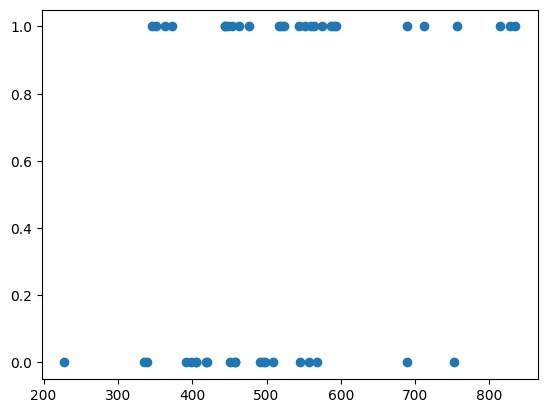

In [60]:
# Max of avg_vel
X, y = getXY(adhd_pos_max_avg_vel, adhd_neg_max_avg_vel)
logit_model = sm.Logit(y, X)
result = logit_model.fit()
print(result.summary())
plt.scatter(X, y)

In [61]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression()

model.fit(np.array([X_train]).reshape(-1, 1), np.array([y_train]).reshape(-1, 1))

y_pred = model.predict(np.array([X_test]).reshape(-1, 1))
accuracy_score(y_test, y_pred)

/usr/local/lib/python3.11/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.4

Optimization terminated successfully.
         Current function value: 0.678816
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   48
Model:                          Logit   Df Residuals:                       47
Method:                           MLE   Df Model:                            0
Date:                Wed, 04 Jan 2023   Pseudo R-squ.:                0.009482
Time:                        18:13:07   Log-Likelihood:                -32.583
converged:                       True   LL-Null:                       -32.895
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0050      0.004      1.161      0.246      -0.003       0.014


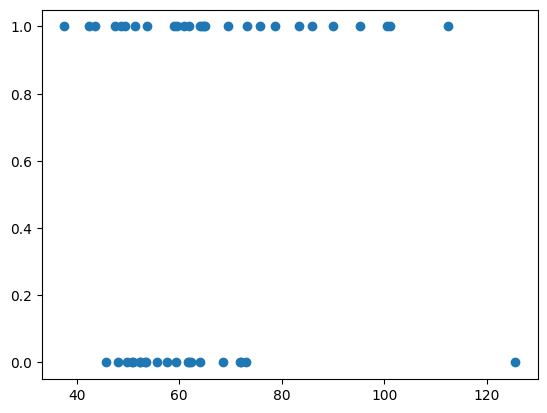

In [62]:
# Mean of avg_vel
X, y = getXY(adhd_pos_mean_avg_vel, adhd_neg_mean_avg_vel)
logit_model = sm.Logit(y, X)
result = logit_model.fit()
print(result.summary())
plt.scatter(X, y)

In [63]:
p_val = stats.mannwhitneyu(adhd_pos_max_avg_vel, adhd_neg_max_avg_vel)[1]
p_val

0.02759745819082515

In [64]:
clf.show_gaze(pp=clf.preproc(data), events=events)

NameError: name 'clf' is not defined

In [ ]:
filtered_x = heuristic_spike_filter(raw_x)
plt.plot(filtered_x)

In [ ]:
filtered_y = heuristic_spike_filter(raw_y)
plt.plot(filtered_y)

In [ ]:
# Euclidean distance
# Input: (x1, y1), (x2, y2)
def euclidean_dist(point1, point2):
    return np.sqrt(np.square(point1[0] - point2[0]) + np.square(point1[1] - point2[1]))

# Point-to-point velocity
# Input: (x1, y1), (x2, y2)
def ptp_velocity(point1, point2, t1, t2):
    return euclidean_dist(point1, point2) / (t2 - t1)

# Point-to-point velocities for a given interval
# Input: df 
def ptp_velocities(data):
    velocities = []
    for idx, row in data.iterrows():
        if idx + 1 < len(data):
            pass

print(euclidean_dist(5, 0, 100, 0))
print(ptp_velocity(5, 0, 100, 0, 5, 10))

# Scanpath Analysis

In [ ]:
plt.plot(test['Position_1'], test['Position_2'])

In [ ]:
plt.plot(fetch_data(45)['Position_1'], fetch_data(45)['Position_2'])

In [ ]:
test.where(test['Events'])